In [1]:
import collections
from pathlib import Path
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Get the Football dataset and put it in the data/bundesliga directory
!curl -LO https://github.com/footballcsv/deutschland/archive/master.zip
!unzip -oq master.zip
!rm master.zip
!mv -f deutschland-master data/bundesliga

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   128  100   128    0     0   1084      0 --:--:-- --:--:-- --:--:--  1084
100  408k  100  408k    0     0   363k      0  0:00:01  0:00:01 --:--:-- 1094k


In [3]:
def process_season_df(df, season, decade):
    df['Season'] = season
    df['Decade'] = decade
    
    # extract round from Team 1
    df['Round'] = df['Team 1'].str.extract('\((\d+)\)')

    df['Order'] = season + '-' + df['Round'].str.zfill(2)
    
    # drop the round from team names
    for team in ['Team 1', 'Team 2']:
        df[team] = df[team].str.extract('(.*) \(.*\)')
    
    # extract the winner
    df['Home goals'] = df['FT'].str.extract('(\d+)-\d+').astype('int')[0]
    df['Away goals'] = df['FT'].str.extract('\d+-(\d+)').astype('int')[0]
    home_winner = df['Home goals'] > df['Away goals']
    away_winner = df['Away goals'] > df['Home goals']
    draw = df['Home goals'] == df['Away goals']
    
    df['Result'] = 0.5
    df.loc[home_winner, 'Result'] = 1
    df.loc[away_winner, 'Result'] = 0

    df = df.drop(columns=['Round', 'Date', 'FT', 'HT'])
    return df
    
    
def read_season_csvs(path, glob_patterns):
    season_dfs = []
    csvs = itertools.chain.from_iterable(path.glob(glob_pattern) for glob_pattern in glob_patterns)
    for csv in csvs:
        season_df = pd.read_csv(csv)
        season_df = process_season_df(season_df, csv.parent.stem, csv.parent.parent.stem)
        season_dfs.append(season_df)
    result_df = pd.concat(season_dfs)
    result_df = result_df.sort_values('Order')
    return result_df

dataset = read_season_csvs(Path.cwd() / 'data' / 'bundesliga', [f'{decade}/*/de.1.csv' for decade in ['2010s']])
dataset

,Team 1,Team 2,Season,Decade,Order,Home goals,Away goals,Result
8,1. FSV Mainz 05,VfB Stuttgart,2010-11,2010s,2010-11-01,2,0,1.0
0,Bayern München,VfL Wolfsburg,2010-11,2010s,2010-11-01,2,1,1.0
1,1. FC Köln,1. FC Kaiserslautern,2010-11,2010s,2010-11-01,1,3,0.0
2,SC Freiburg,FC St. Pauli,2010-11,2010s,2010-11-01,1,3,0.0
3,Hamburger SV,FC Schalke 04,2010-11,2010s,2010-11-01,2,1,1.0
...,...,...,...,...,...,...,...,...
219,VfL Wolfsburg,RB Leipzig,2019-20,2010s,2019-20-25,0,0,0.5
215,SC Freiburg,1. FC Union Berlin,2019-20,2010s,2019-20-25,3,1,1.0
221,Bayern München,FC Augsburg,2019-20,2010s,2019-20-25,2,0,1.0
222,1. FSV Mainz 05,Fortuna Düsseldorf,2019-20,2010s,2019-20-25,1,1,0.5


In [4]:
dataset['Result'].value_counts()

1.0    1359
0.0     903
0.5     716
Name: Result, dtype: int64

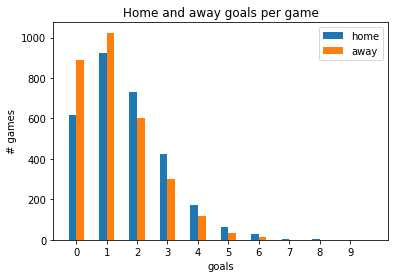

In [5]:
max_goals = 10
_ = plt.hist(dataset['Home goals'], bins=np.arange(-0.25, 10.25), label='home', width=0.25, align='mid')
_ = plt.hist(dataset['Away goals'], bins=np.arange(0, 10), label='away', width=0.25, align='mid')
# _ = plt.bar(np.arange(max_goals) + 0.15, [away_goals.get(i, 0) for i in range(max_goals)], width=0.3, label='away')
_ = plt.legend()
_ = plt.xticks(range(max_goals))
_ = plt.xlabel('goals')
_ = plt.ylabel('# games')
_ = plt.title('Home and away goals per game')

In [6]:
ELO_K = 20
ELO_START_RATING = 1200

def expected(rating_a, rating_b):
    rating_diff = rating_b - rating_a
    if rating_diff > 400:
        rating_diff = 400
    if rating_diff < -400:
        rating_diff = -400
    return 1 / (1 + 10**(rating_diff/400))

def elo_update(rating_home, rating_away, result):
    expected_home = expected(rating_home, rating_away)
    expected_away = 1 - expected_home
    points_home = result
    points_away = 1 - result
    
    new_rating_home = rating_home + ELO_K * (points_home - expected_home)
    new_rating_away = rating_away + ELO_K * (points_away - expected_away)
    return new_rating_home, new_rating_away

In [7]:
def elo_rate(dataset):
    ratings = collections.defaultdict(lambda: [ELO_START_RATING])
    for _, game in dataset.iterrows():
        home, away = game['Team 1'], game['Team 2']
        new_home_rating, new_away_rating = elo_update(ratings[home][-1], ratings[away][-1], game['Result'])
        ratings[home].append(new_home_rating)
        ratings[away].append(new_away_rating)
    return dict(ratings)

train_set = dataset[dataset['Season'] != '2019-20'].copy()
test_set = dataset[dataset['Season'] == '2019-20'].copy()
ratings_progression = elo_rate(train_set)
ratings_final = {k: v[-1] for k, v in ratings_progression.items()}

In [8]:
teams_df = pd.DataFrame()
teams_df['Team'] = dataset['Team 1'].unique()
teams_df['ELO Progression'] = teams_df['Team'].apply(lambda team: ratings_progression.get(team))
teams_df['ELO Final'] = teams_df['ELO Progression'].apply(lambda prog: prog[-1] if prog is not None else None)
teams_df = teams_df.set_index('Team')
teams_df.sort_values('ELO Final', ascending=False).head(10)

,ELO Progression,ELO Final
Team,,
Bayern München,"[1200, 1210.0, 1200.0, 1200.0, 1199.7287935411...",1498.661765
Borussia Dortmund,"[1200, 1190.0, 1200.0, 1209.4414857108948, 121...",1388.091013
RB Leipzig,"[1200, 1199.6385278423593, 1214.6570500539767,...",1341.342020
Bayer 04 Leverkusen,"[1200, 1210.0, 1199.71225631668, 1200.27902631...",1302.955986
TSG 1899 Hoffenheim,"[1200, 1210.0, 1220.0, 1228.8701031196488, 122...",1280.642915
Werder Bremen,"[1200, 1190.0, 1200.0, 1200.0, 1190.8453730911...",1279.330308
Bor. Mönchengladbach,"[1200, 1200.0, 1210.28774368332, 1199.43462131...",1252.442285
Eintracht Frankfurt,"[1200, 1190.0, 1180.5750112778453, 1191.428133...",1251.550320
VfL Wolfsburg,"[1200, 1190.0, 1180.5750112778453, 1171.133525...",1245.742907


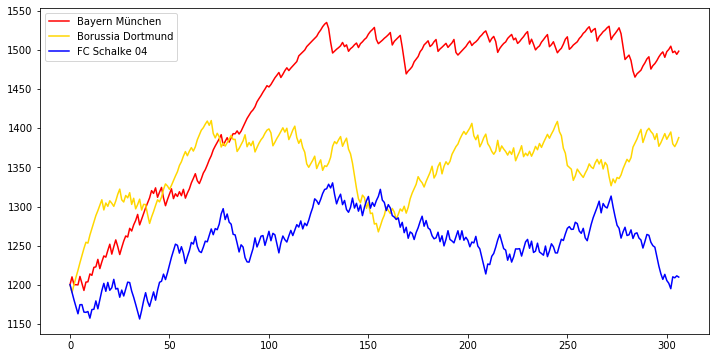

In [9]:
bayern, dortmund, schalke = teams_df.loc[['Bayern München', 'Borussia Dortmund', 'FC Schalke 04']]['ELO Progression'].to_list()
fig = plt.Figure(figsize=(12,6))
ax = fig.gca()
_ = ax.plot(bayern, c='red', label='Bayern München')
_ = ax.plot(dortmund, c='gold', label='Borussia Dortmund')
_ = ax.plot(schalke, c='blue', label='FC Schalke 04')
_ = ax.legend()
fig

In [10]:
def elo_predict_single(home, away, ratings):
    return expected(ratings[home], ratings[away])

print('Bayern vs Köln', elo_predict_single('Bayern München', '1. FC Köln', ratings_final))

def elo_predict(dataset, ratings):
    results = []
    for ind, game in dataset.iterrows():
        if game['Team 1'] in ratings and game['Team 2'] in ratings:
            results.append(elo_predict_single(game['Team 1'], game['Team 2'], ratings))
        else:
            results.append(None)
    return pd.Series(results)

predictions = elo_predict(test_set, ratings_final)

Bayern vs Köln 0.8904235533514515


In [11]:
test_set['ELO prediction'] = predictions
test_set = test_set.dropna().copy()
test_set['Prediction error'] = test_set['Result'] - test_set['ELO prediction']


print('Always home win MSE:    ', np.mean((test_set['Result'] - 1).values**2))
print('Always predict draw MSE:', np.mean((test_set['Result'] - 0.5).values**2))
print('ELO MSE:                ', np.mean(test_set['Prediction error'].values**2))

Always home win MSE:     0.3957286432160804
Always predict draw MSE: 0.19597989949748743
ELO MSE:                 0.2019757440096987
